# Library

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import datetime
import os


# Read Data

In [2]:
file_path = 'combined_data1.csv'

df = pd.read_csv(file_path)
df

,Title,Day,Hour,OccupancyPercent
0,9/11 Cafe & Concept Store,Su,6,0
1,9/11 Cafe & Concept Store,Su,7,0
2,9/11 Cafe & Concept Store,Su,8,0
3,9/11 Cafe & Concept Store,Su,9,9
4,9/11 Cafe & Concept Store,Su,10,20
...,...,...,...,...
1129,Batu Bolong Temple,Sa,18,88
1130,Batu Bolong Temple,Sa,19,0
1131,Batu Bolong Temple,Sa,20,0
1132,Batu Bolong Temple,Sa,21,0


# Data Preprocessing

## Missing Value

In [3]:
df.isnull().sum()

,0
Title,0
Day,0
Hour,0
OccupancyPercent,0


## Duplicate Value

In [4]:
df.duplicated().sum()

0

# Fitur Enginering

## Add Date, Month, Day of Week

In [5]:
# Menbuat date range untuk 2024
start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2024-11-30')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

In [6]:
# Mapping hari dan lokasi unik
day_mapping = {
    0: 'Mo',
    1: 'Tu',
    2: 'We',
    3: 'Th',
    4: 'Fr',
    5: 'Sa',
    6: 'Su'
}

unique_locations = df['Title'].unique()


In [7]:
synthetic_data = []

# Untuk setiap lokasi
for location in unique_locations:
    # Untuk setiap tanggal 2024
    for date in date_range:
        # Get the day abbreviation
        day_abbr = day_mapping[date.weekday()]

        # Dapatkan pola okupansi untuk hari ini dari data asli
        day_patterns = df[
            (df['Title'] == location) &
            (df['Day'] == day_abbr)
        ][['Hour', 'OccupancyPercent']].values

        # Untuk setiap pola jam dalam data asli
        for hour, occupancy in day_patterns:
            synthetic_data.append({
                'Title': location,
                'Date': date,
                'Day': day_abbr,
                'Hour': hour,
                'OccupancyPercent': occupancy,
                'Month': date.month,
                'DayOfWeek': date.weekday()
            })

df_new = pd.DataFrame(synthetic_data)

In [8]:
df_new

,Title,Date,Day,Hour,OccupancyPercent,Month,DayOfWeek
0,9/11 Cafe & Concept Store,2024-01-01,Mo,6,0,1,0
1,9/11 Cafe & Concept Store,2024-01-01,Mo,7,0,1,0
2,9/11 Cafe & Concept Store,2024-01-01,Mo,8,0,1,0
3,9/11 Cafe & Concept Store,2024-01-01,Mo,9,12,1,0
4,9/11 Cafe & Concept Store,2024-01-01,Mo,10,25,1,0
...,...,...,...,...,...,...,...
54265,Batu Bolong Temple,2024-11-30,Sa,18,88,11,5
54266,Batu Bolong Temple,2024-11-30,Sa,19,0,11,5
54267,Batu Bolong Temple,2024-11-30,Sa,20,0,11,5
54268,Batu Bolong Temple,2024-11-30,Sa,21,0,11,5


## Sesional

In [9]:
def apply_seasonal_adjustment(row):
    # High Season: Liburan internasional dan lokal
    if row['Month'] in [6, 7, 8, 12]:
        adjustment = 1.2
    # Low Season: Musim hujan dan setelah liburan panjang
    elif row['Month'] in [1, 2, 3]:
        adjustment = 0.7
    # Shoulder Season: Peralihan
    else:
        adjustment = 1.0  # Tidak ada perubahan

    new_occupancy = min(100, row['OccupancyPercent'] * adjustment)
    return max(0, new_occupancy)

df_new['OccupancyPercent'] = df_new.apply(apply_seasonal_adjustment, axis=1)

In [10]:
df_new

,Title,Date,Day,Hour,OccupancyPercent,Month,DayOfWeek
0,9/11 Cafe & Concept Store,2024-01-01,Mo,6,0.0,1,0
1,9/11 Cafe & Concept Store,2024-01-01,Mo,7,0.0,1,0
2,9/11 Cafe & Concept Store,2024-01-01,Mo,8,0.0,1,0
3,9/11 Cafe & Concept Store,2024-01-01,Mo,9,8.4,1,0
4,9/11 Cafe & Concept Store,2024-01-01,Mo,10,17.5,1,0
...,...,...,...,...,...,...,...
54265,Batu Bolong Temple,2024-11-30,Sa,18,88.0,11,5
54266,Batu Bolong Temple,2024-11-30,Sa,19,0.0,11,5
54267,Batu Bolong Temple,2024-11-30,Sa,20,0.0,11,5
54268,Batu Bolong Temple,2024-11-30,Sa,21,0.0,11,5


In [11]:
# Fungsi untuk menentukan musim berdasarkan bulan
def get_season(month):
    if month in [6, 7, 8]:
        return 'High Season'
    elif month in [12, 1, 2]:
        return 'Low Season'
    else:
        return 'Shoulder Season'

df_new['Month'] = pd.to_datetime(df_new['Date']).dt.month
df_new['Season'] = df_new['Month'].apply(get_season)

df_new

,Title,Date,Day,Hour,OccupancyPercent,Month,DayOfWeek,Season
0,9/11 Cafe & Concept Store,2024-01-01,Mo,6,0.0,1,0,Low Season
1,9/11 Cafe & Concept Store,2024-01-01,Mo,7,0.0,1,0,Low Season
2,9/11 Cafe & Concept Store,2024-01-01,Mo,8,0.0,1,0,Low Season
3,9/11 Cafe & Concept Store,2024-01-01,Mo,9,8.4,1,0,Low Season
4,9/11 Cafe & Concept Store,2024-01-01,Mo,10,17.5,1,0,Low Season
...,...,...,...,...,...,...,...,...
54265,Batu Bolong Temple,2024-11-30,Sa,18,88.0,11,5,Shoulder Season
54266,Batu Bolong Temple,2024-11-30,Sa,19,0.0,11,5,Shoulder Season
54267,Batu Bolong Temple,2024-11-30,Sa,20,0.0,11,5,Shoulder Season
54268,Batu Bolong Temple,2024-11-30,Sa,21,0.0,11,5,Shoulder Season


## Holidays

In [12]:
holidays_2024 = {
    '2024-01-01': 'New Year',
}

holidays_dates = pd.to_datetime(list(holidays_2024.keys()))

def apply_holiday_adjustment(row):
    if pd.to_datetime(row['Date']) in holidays_dates:
        # Tingkatkan okupansi selama jam kerja biasa (10 pagi - 8 malam)
        if 10 <= row['Hour'] <= 20:
            return min(100, row['OccupancyPercent'] * 1.5)
    return row['OccupancyPercent']

df_new['OccupancyPercent'] = df_new.apply(apply_holiday_adjustment, axis=1)

In [13]:
df_new['Date'] = pd.to_datetime(df_new['Date']).dt.strftime('%Y-%m-%d')
df_new['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 54270 entries, 0 to 54269
Series name: Date
Non-Null Count  Dtype 
--------------  ----- 
54270 non-null  object
dtypes: object(1)
memory usage: 424.1+ KB


In [14]:
# Mapping untuk hari-hari tertentu
special_days = {
    '2024-01-01': 'New Year',
}

df_new['Holiday'] = df_new['Date'].map(special_days).fillna('Normal Day')

day_mapping = {
    'Su': 'Sunday',
    'Mo': 'Monday',
    'Tu': 'Tuesday',
    'We': 'Wednesday',
    'Th': 'Thursday',
    'Fr': 'Friday',
    'Sa': 'Saturday'
}

df_new['Day'] = df_new['Day'].map(day_mapping)

df_new

,Title,Date,Day,Hour,OccupancyPercent,Month,DayOfWeek,Season,Holiday
0,9/11 Cafe & Concept Store,2024-01-01,Monday,6,0.00,1,0,Low Season,New Year
1,9/11 Cafe & Concept Store,2024-01-01,Monday,7,0.00,1,0,Low Season,New Year
2,9/11 Cafe & Concept Store,2024-01-01,Monday,8,0.00,1,0,Low Season,New Year
3,9/11 Cafe & Concept Store,2024-01-01,Monday,9,8.40,1,0,Low Season,New Year
4,9/11 Cafe & Concept Store,2024-01-01,Monday,10,26.25,1,0,Low Season,New Year
...,...,...,...,...,...,...,...,...,...
54265,Batu Bolong Temple,2024-11-30,Saturday,18,88.00,11,5,Shoulder Season,Normal Day
54266,Batu Bolong Temple,2024-11-30,Saturday,19,0.00,11,5,Shoulder Season,Normal Day
54267,Batu Bolong Temple,2024-11-30,Saturday,20,0.00,11,5,Shoulder Season,Normal Day
54268,Batu Bolong Temple,2024-11-30,Saturday,21,0.00,11,5,Shoulder Season,Normal Day


## Days

In [15]:
# Tambahkan variasi acak kecil (±10%)
np.random.seed(42)
df_new['OccupancyPercent'] = df_new['OccupancyPercent'].apply(
    lambda x: max(0, min(100, x * (1 + np.random.uniform(-0.1, 0.1))))
)

In [16]:
# Sort data
df_new = df_new.sort_values(['Title', 'Date', 'Hour']).reset_index(drop=True)

def get_time_category(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_new['TimeCategory'] = df_new['Hour'].apply(get_time_category)

df_new

,Title,Date,Day,Hour,OccupancyPercent,Month,DayOfWeek,Season,Holiday,TimeCategory
0,9/11 Cafe & Concept Store,2024-01-01,Monday,6,0.000000,1,0,Low Season,New Year,Morning
1,9/11 Cafe & Concept Store,2024-01-01,Monday,7,0.000000,1,0,Low Season,New Year,Morning
2,9/11 Cafe & Concept Store,2024-01-01,Monday,8,0.000000,1,0,Low Season,New Year,Morning
3,9/11 Cafe & Concept Store,2024-01-01,Monday,9,8.565746,1,0,Low Season,New Year,Morning
4,9/11 Cafe & Concept Store,2024-01-01,Monday,10,24.444098,1,0,Low Season,New Year,Morning
...,...,...,...,...,...,...,...,...,...,...
54265,Batu Bolong Temple,2024-11-30,Saturday,18,79.248233,11,5,Shoulder Season,Normal Day,Evening
54266,Batu Bolong Temple,2024-11-30,Saturday,19,0.000000,11,5,Shoulder Season,Normal Day,Evening
54267,Batu Bolong Temple,2024-11-30,Saturday,20,0.000000,11,5,Shoulder Season,Normal Day,Evening
54268,Batu Bolong Temple,2024-11-30,Saturday,21,0.000000,11,5,Shoulder Season,Normal Day,Night


## To CSV

In [17]:
df_new.to_csv('combined_dataa.csv', index=False)

# Data Explore

In [18]:
df_new

,Title,Date,Day,Hour,OccupancyPercent,Month,DayOfWeek,Season,Holiday,TimeCategory
0,9/11 Cafe & Concept Store,2024-01-01,Monday,6,0.000000,1,0,Low Season,New Year,Morning
1,9/11 Cafe & Concept Store,2024-01-01,Monday,7,0.000000,1,0,Low Season,New Year,Morning
2,9/11 Cafe & Concept Store,2024-01-01,Monday,8,0.000000,1,0,Low Season,New Year,Morning
3,9/11 Cafe & Concept Store,2024-01-01,Monday,9,8.565746,1,0,Low Season,New Year,Morning
4,9/11 Cafe & Concept Store,2024-01-01,Monday,10,24.444098,1,0,Low Season,New Year,Morning
...,...,...,...,...,...,...,...,...,...,...
54265,Batu Bolong Temple,2024-11-30,Saturday,18,79.248233,11,5,Shoulder Season,Normal Day,Evening
54266,Batu Bolong Temple,2024-11-30,Saturday,19,0.000000,11,5,Shoulder Season,Normal Day,Evening
54267,Batu Bolong Temple,2024-11-30,Saturday,20,0.000000,11,5,Shoulder Season,Normal Day,Evening
54268,Batu Bolong Temple,2024-11-30,Saturday,21,0.000000,11,5,Shoulder Season,Normal Day,Night


In [19]:
# Grouping berdasarkan Time dan Holiday
result = df_new.groupby(['TimeCategory', 'Holiday'])['OccupancyPercent'].mean().reset_index()

# Mengatur ulang kolom untuk mempermudah pembacaan
result.rename(columns={'Value': 'Avg Occupancy Percent'}, inplace=True)

result

,TimeCategory,Holiday,OccupancyPercent
0,Afternoon,New Year,61.029134
1,Afternoon,Normal Day,62.327479
2,Evening,New Year,35.936127
3,Evening,Normal Day,35.284971
4,Morning,New Year,26.991500
5,Morning,Normal Day,30.609936
6,Night,New Year,9.691132
7,Night,Normal Day,14.318501


## Bar Plot: Visualisasi Distribusi Rata-rata Okupansi berdasarkan Kategori Waktu dan Hari Libur

<ipython-input-20-b704bdb93400>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


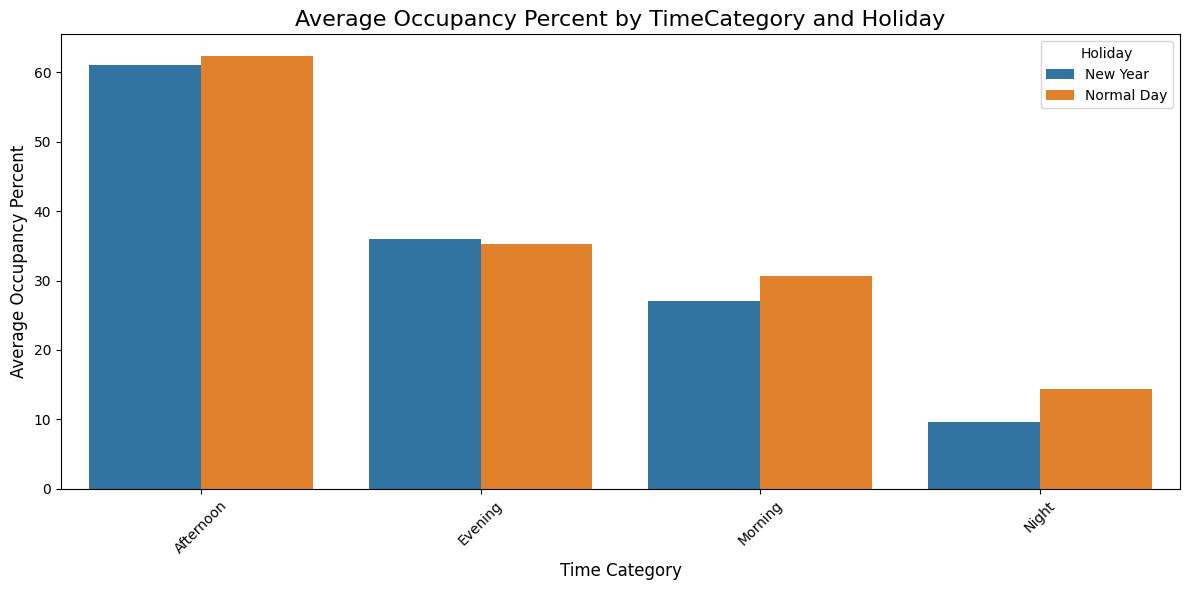

In [20]:
# Membuat bar plot untuk distribusi rata-rata okupansi
plt.figure(figsize=(12, 6))
sns.barplot(
    data=result,
    x='TimeCategory',
    y='OccupancyPercent',
    hue='Holiday',  # Memisahkan berdasarkan kategori 'Holiday'
    ci=None
)
plt.title('Average Occupancy Percent by TimeCategory and Holiday', fontsize=16)
plt.xlabel('Time Category', fontsize=12)
plt.ylabel('Average Occupancy Percent', fontsize=12)
plt.legend(title='Holiday', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Bar plot ini menunjukkan rata-rata okupansi berdasarkan kategori waktu (misalnya Pagi, Siang, Malam) dan status hari libur (Libur vs Biasa).

Insight dari Bar Plot:
Peningkatan okupansi di waktu tertentu:


---



Anda dapat mengamati apakah waktu-waktu tertentu dalam sehari seperti siang atau sore memiliki okupansi lebih tinggi dibandingkan waktu lain. Misalnya, bisa jadi waktu siang hari lebih banyak pengunjungnya daripada pagi atau malam.
Hari-hari libur sering kali memiliki okupansi yang lebih tinggi di waktu tertentu (misalnya di siang hari), yang bisa menunjukkan lebih banyak pengunjung yang datang saat liburan dibandingkan hari biasa.
Pengaruh Hari Libur terhadap Okupansi:

Hari libur seperti Natal atau Tahun Baru kemungkinan besar menunjukkan okupansi yang lebih tinggi pada siang hari karena banyak orang memiliki waktu luang untuk berkunjung, sementara pada hari biasa, okupansi di waktu pagi atau malam bisa lebih tinggi.
Jika terlihat, hari biasa dapat menunjukkan okupansi yang lebih tinggi di pagi atau malam hari, ketika orang lebih cenderung datang setelah bekerja atau saat tempat tersebut tidak terlalu ramai.
Polarisasi Okupansi pada Waktu Tertentu:

Anda bisa mendapatkan wawasan apakah ada waktu puncak tertentu (misalnya, tengah hari atau sore) yang memiliki okupansi lebih tinggi dibandingkan waktu lain, baik di hari libur maupun hari biasa.
Hal ini dapat membantu dalam merencanakan promosi atau strategi pemasaran untuk menarik pengunjung pada waktu-waktu yang kurang sibuk.

## Distribusi Okupansi berdasarkan Bulan (Month)

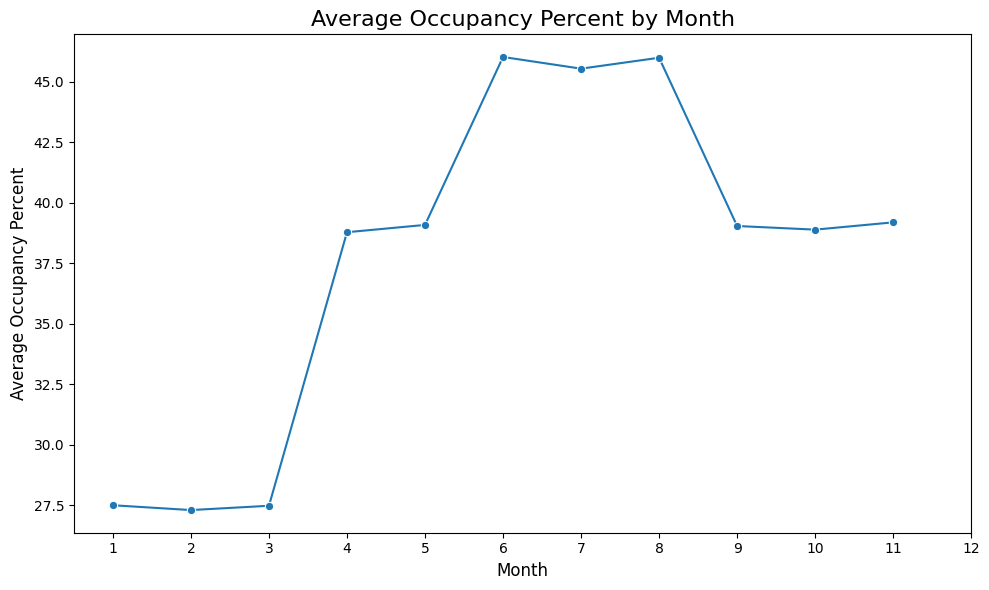

In [21]:
monthly_result = df_new.groupby('Month')['OccupancyPercent'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='OccupancyPercent', data=monthly_result, marker='o')
plt.title('Average Occupancy Percent by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Occupancy Percent', fontsize=12)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()


## Heatmap: Hubungan antara TimeCategory dan Holiday berdasarkan Rata-rata Okupansi

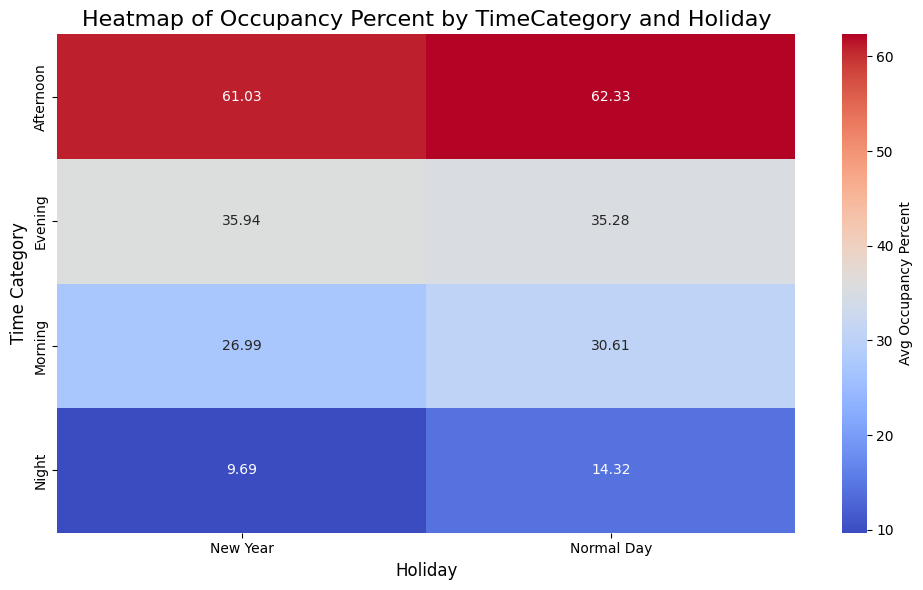

In [22]:
# Pivot tabel untuk heatmap
heatmap_data = result.pivot_table(
    index='TimeCategory',
    columns='Holiday',
    values='OccupancyPercent',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar_kws={'label': 'Avg Occupancy Percent'}
)
plt.title('Heatmap of Occupancy Percent by TimeCategory and Holiday', fontsize=16)
plt.xlabel('Holiday', fontsize=12)
plt.ylabel('Time Category', fontsize=12)
plt.tight_layout()
plt.show()


Heatmap ini memberikan gambaran perbandingan antara kategori waktu dan hari libur, menggambarkan rata-rata okupansi di berbagai kombinasi.

Insight dari Heatmap:
Okupansi Lebih Tinggi pada Waktu Tertentu (Malam/Siang):


---



Heatmap dapat menunjukkan bahwa pada hari libur, terutama pada waktu siang dan sore, okupansi lebih tinggi dibandingkan waktu pagi. Hal ini terjadi karena pengunjung cenderung lebih bebas mengunjungi tempat wisata atau restoran selama waktu liburan.
Perbandingan Hari Libur dan Hari Biasa:

Dapat dilihat apakah hari libur, seperti Natal atau Tahun Baru, memiliki okupansi yang lebih merata di seluruh waktu (pagi, siang, malam), atau apakah ada waktu tertentu yang lebih tinggi, seperti siang hari.
Jika di hari biasa, okupansi lebih banyak di waktu malam atau pagi (misalnya, orang datang sebelum bekerja atau pada waktu lebih tenang), ini memberikan informasi berharga bagi strategi pengelolaan waktu operasional tempat usaha.
Efek Musiman dan Pola Jangka Panjang:

Pola okupansi di waktu-waktu tertentu juga dapat mencerminkan efek musiman, misalnya musim liburan memberikan pengaruh besar pada okupansi saat hari libur, sementara pada hari biasa, tingkat okupansi mungkin lebih rendah tetapi konsisten sepanjang waktu.
Strategi Penyesuaian Waktu:

Heatmap dapat mengungkap waktu yang perlu perhatian lebih (misalnya, jika ada banyak ruang kosong pada waktu tertentu), yang bisa mendorong penyesuaian jam operasional atau promosi untuk mengisi tempat pada waktu-waktu tertentu.

# Model

## LSTM

### Read Data for Model

In [23]:
df1 = pd.read_csv('combined_dataa.csv')

df1

,Title,Date,Day,Hour,OccupancyPercent,Month,DayOfWeek,Season,Holiday,TimeCategory
0,9/11 Cafe & Concept Store,2024-01-01,Monday,6,0.000000,1,0,Low Season,New Year,Morning
1,9/11 Cafe & Concept Store,2024-01-01,Monday,7,0.000000,1,0,Low Season,New Year,Morning
2,9/11 Cafe & Concept Store,2024-01-01,Monday,8,0.000000,1,0,Low Season,New Year,Morning
3,9/11 Cafe & Concept Store,2024-01-01,Monday,9,8.565746,1,0,Low Season,New Year,Morning
4,9/11 Cafe & Concept Store,2024-01-01,Monday,10,24.444098,1,0,Low Season,New Year,Morning
...,...,...,...,...,...,...,...,...,...,...
54265,Batu Bolong Temple,2024-11-30,Saturday,18,79.248233,11,5,Shoulder Season,Normal Day,Evening
54266,Batu Bolong Temple,2024-11-30,Saturday,19,0.000000,11,5,Shoulder Season,Normal Day,Evening
54267,Batu Bolong Temple,2024-11-30,Saturday,20,0.000000,11,5,Shoulder Season,Normal Day,Evening
54268,Batu Bolong Temple,2024-11-30,Saturday,21,0.000000,11,5,Shoulder Season,Normal Day,Night


### Get All Location From Data

In [24]:
df1['Title'].unique()

array(['9/11 Cafe & Concept Store', 'AKASA Specialty Coffee',
       'Air Terjun Munduk', 'Aling-Aling Waterfall', 'BAKED. Berawa',
       'BANDUNG COLLECTION JIMBARAN', 'BATIK Restaurant',
       'Banyumala twin waterfalls', 'Batu Bolong Temple'], dtype=object)

### Train All Location

Processing location: 9/11 Cafe & Concept Store


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1195 - val_loss: 0.0176
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0154 - val_loss: 0.0116
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099 - val_loss: 0.0085
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0085 - val_loss: 0.0127
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0074 - val_loss: 0.0063


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


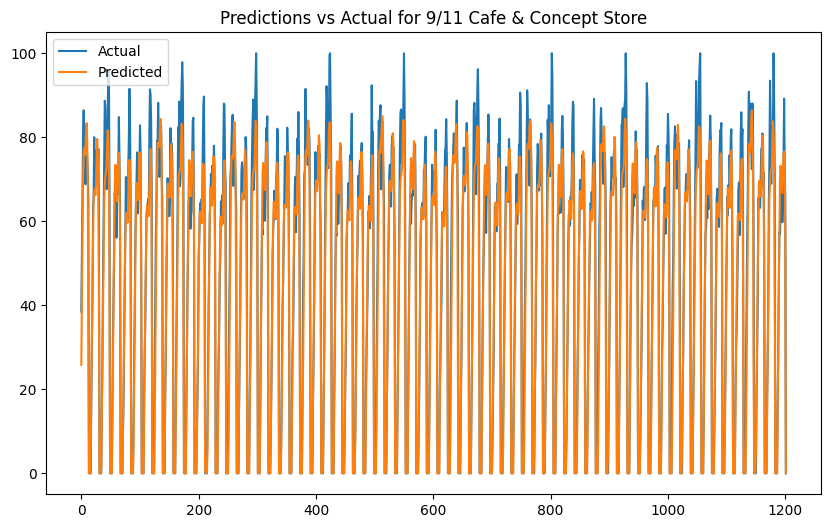

Completed processing for location: 9/11 Cafe & Concept Store

Processing location: AKASA Specialty Coffee
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0948 - val_loss: 0.0142
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - val_loss: 0.0093
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040 - val_loss: 0.0069


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


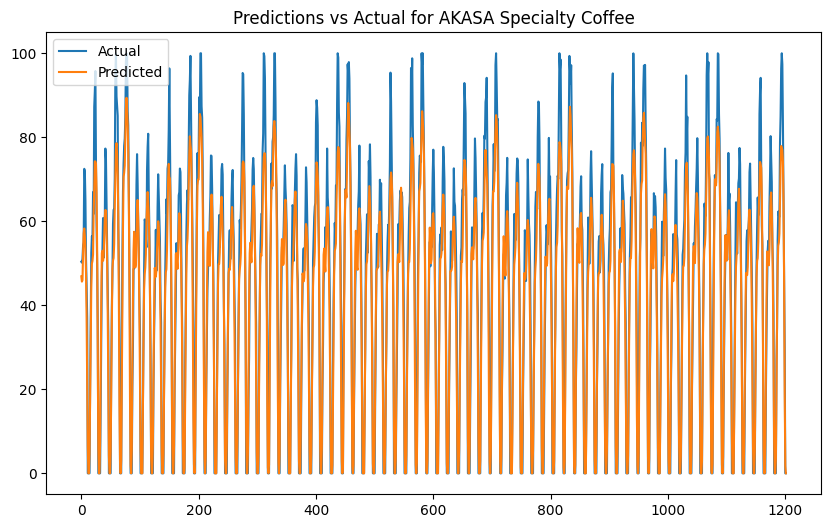

Completed processing for location: AKASA Specialty Coffee

Processing location: Air Terjun Munduk
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0958 - val_loss: 0.0155
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0128 - val_loss: 0.0094
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0096 - val_loss: 0.0089
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0121
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - val_loss: 0.0097
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0056 - val_loss: 0.0076


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


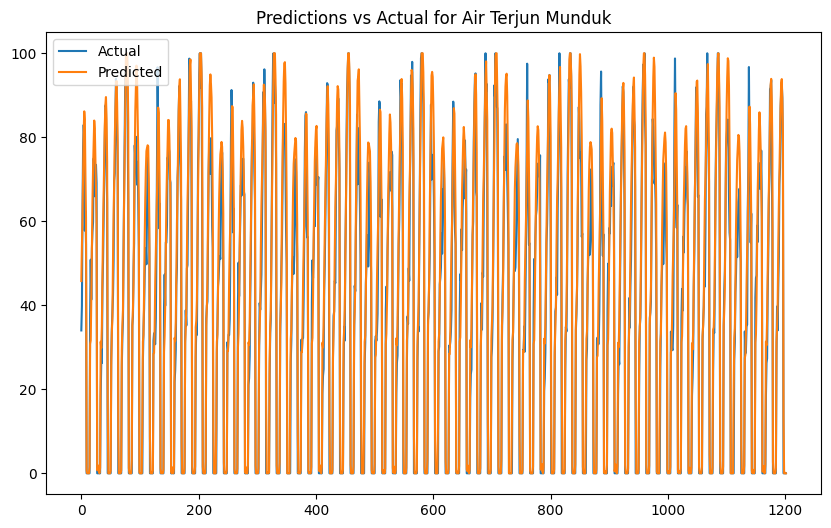

Completed processing for location: Air Terjun Munduk

Processing location: Aling-Aling Waterfall
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0831 - val_loss: 0.0103
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0109 - val_loss: 0.0070
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0045
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0026


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


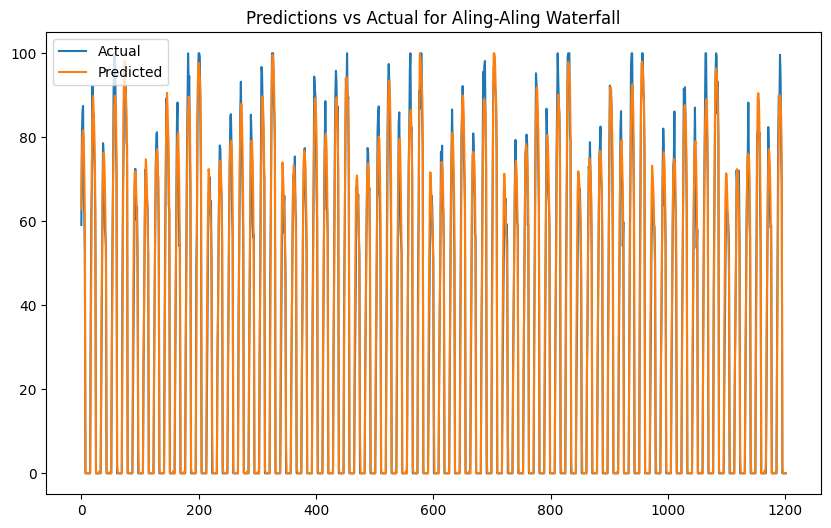

Completed processing for location: Aling-Aling Waterfall

Processing location: BAKED. Berawa
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1116 - val_loss: 0.0076
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077 - val_loss: 0.0063
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0071
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_loss: 0.0036


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


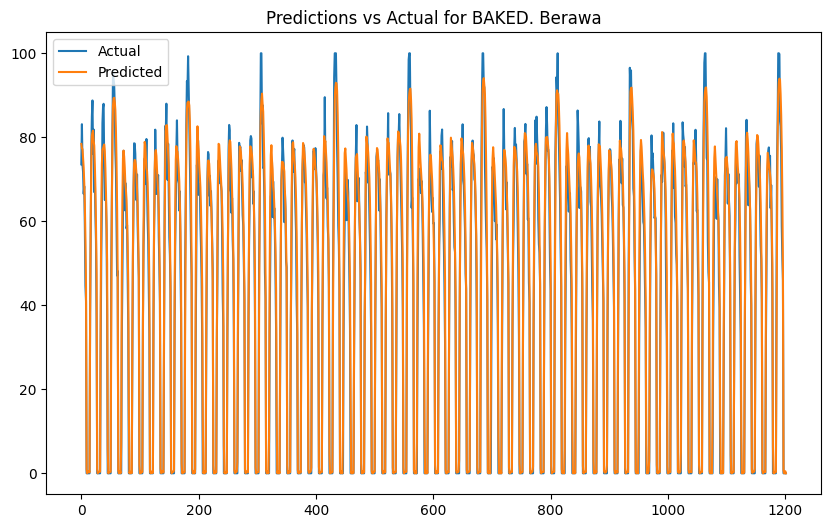

Completed processing for location: BAKED. Berawa

Processing location: BANDUNG COLLECTION JIMBARAN
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0841 - val_loss: 0.0139
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0091 - val_loss: 0.0036
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0042 - val_loss: 0.0059
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0028


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


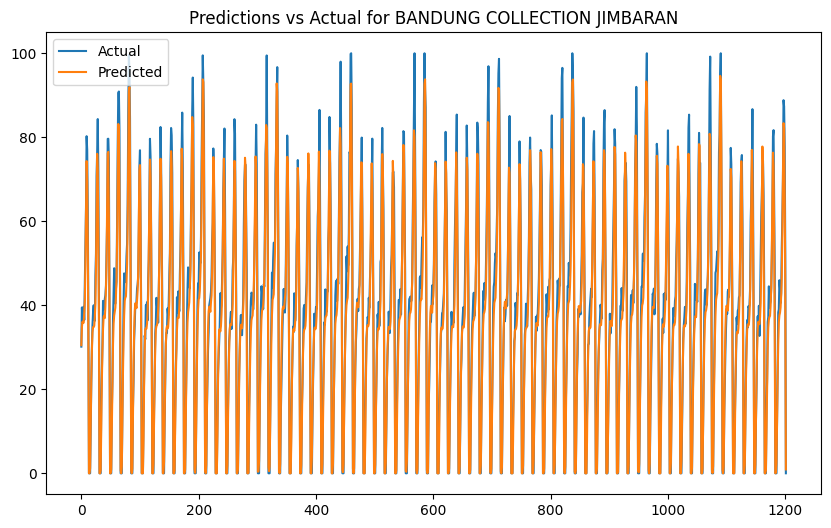

Completed processing for location: BANDUNG COLLECTION JIMBARAN

Processing location: BATIK Restaurant
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0767 - val_loss: 0.0152
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0124 - val_loss: 0.0081
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0080
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - val_loss: 0.0037


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


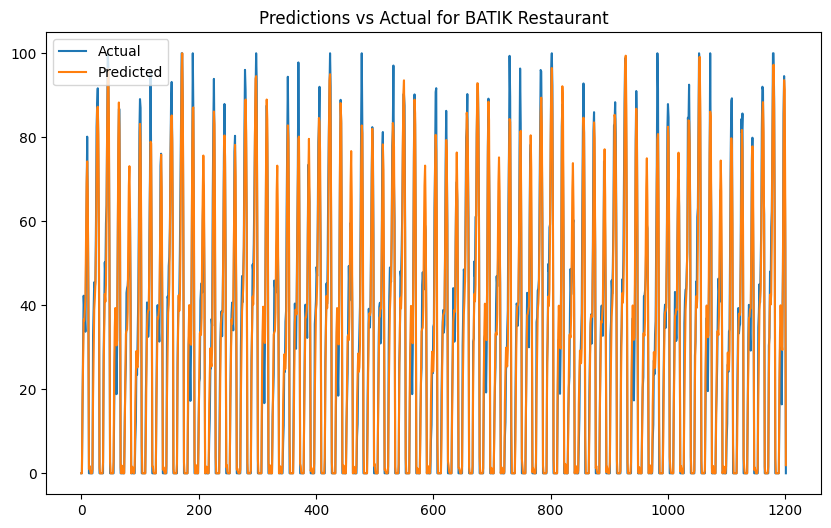

Completed processing for location: BATIK Restaurant

Processing location: Banyumala twin waterfalls
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0661 - val_loss: 0.0056
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - val_loss: 0.0028


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


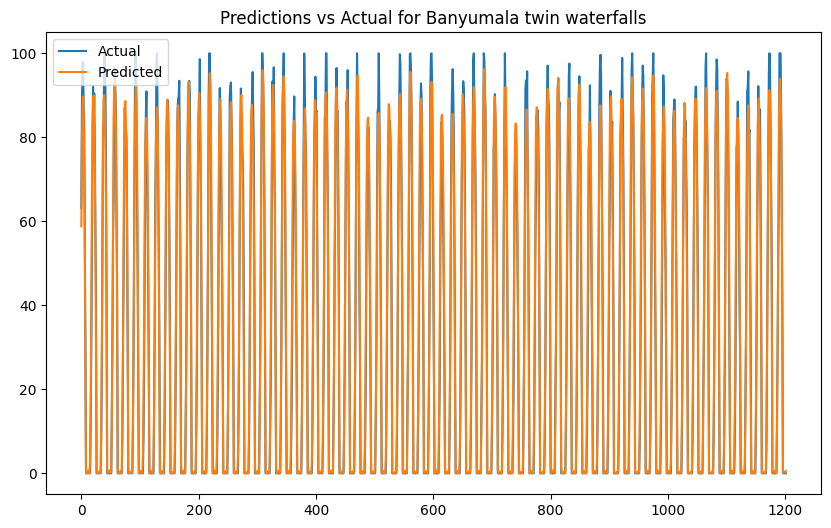

Completed processing for location: Banyumala twin waterfalls

Processing location: Batu Bolong Temple
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1032 - val_loss: 0.0242
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0191 - val_loss: 0.0251
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0146 - val_loss: 0.0099
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0115 - val_loss: 0.0088
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - val_loss: 0.0054
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - val_loss: 0.0032
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - val_loss: 0.0033


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


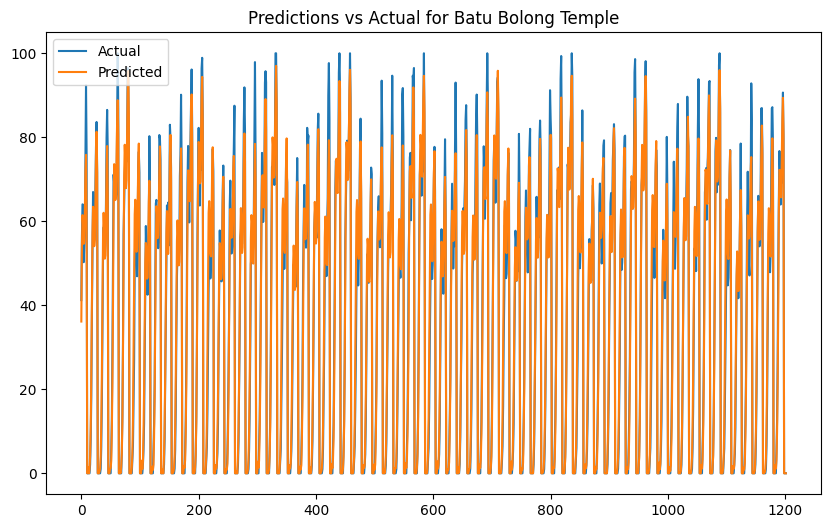

Completed processing for location: Batu Bolong Temple



In [25]:
df1['Year'] = pd.to_datetime(df1['Date']).dt.year
df1['YearMonth'] = pd.to_datetime(df1['Date']).dt.to_period('M').astype(str)

df1 = df1[['Title', 'Date', 'Day', 'Hour', 'OccupancyPercent', 'Year', 'YearMonth']]

locations = df1['Title'].unique()

for location_input in locations:
    print(f"Processing location: {location_input}")

    location_data = df1[df1['Title'] == location_input]

    scaler = MinMaxScaler(feature_range=(0, 1))
    location_data_scaled = scaler.fit_transform(location_data[['OccupancyPercent']])

    window_size = 24
    X, y = [], []
    for i in range(window_size, len(location_data_scaled)):
        X.append(location_data_scaled[i-window_size:i, 0])
        y.append(location_data_scaled[i, 0])
    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_path = f'{location_input}_occupancy_model.h5'
    if os.path.exists(model_path):
        model = load_model(model_path)
    else:
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
            LSTM(50, return_sequences=False),
            Dense(25, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

        model.save(model_path)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    predictions = np.clip(predictions, 0, 100)
    y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_actual = np.clip(y_actual, 0, 100)

    plt.figure(figsize=(10, 6))
    plt.plot(y_actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(f'Predictions vs Actual for {location_input}')
    plt.legend()
    plt.show()

    print(f"Completed processing for location: {location_input}\n")


### Evaluasi RMSE, MAE, R-squared

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Hitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_actual, predictions))
print(f"RMSE: {rmse:.4f}")

# Hitung MAE (Mean Absolute Error)
mae = mean_absolute_error(y_actual, predictions)
print(f"MAE: {mae:.4f}")

# Hitung R-squared (R²)
r2 = r2_score(y_actual, predictions)
print(f"R-squared: {r2:.4f}")

RMSE: 5.7152
MAE: 3.9108
R-squared: 0.9692


1. **RMSE (Root Mean Squared Error): 5.7152**
   - **RMSE** menunjukkan rata-rata kesalahan kuadrat antara nilai aktual dan prediksi.
   - Nilai RMSE sebesar **5.01** mengindikasikan bahwa prediksi model rata-rata memiliki kesalahan sekitar **5.7%** dari nilai yang sebenarnya. Nilai ini relatif kecil dibandingkan dengan rentang data (0–100%), menunjukkan performa prediksi yang baik.

---

2. **MAE (Mean Absolute Error): 3.9108**
   - **MAE** menunjukkan rata-rata kesalahan absolut antara nilai aktual dan prediksi.
   - Dengan nilai MAE sebesar **3.9108**, rata-rata kesalahan absolut antara nilai aktual dan prediksi adalah sekitar **3.9%**. MAE memberikan gambaran yang lebih langsung tentang jarak rata-rata antara prediksi dan nilai aktual.

---

3. **R-squared (R²): 0.9692**
   - **R²** mengukur seberapa baik model dapat menjelaskan variabilitas dalam data.
   - Nilai **0.96** berarti model dapat menjelaskan **96%** dari variabilitas dalam data OccupancyPercent. Hal ini menunjukkan bahwa model memiliki kemampuan yang sangat baik untuk menangkap pola dalam data.

---

**Kesimpulan**:
- **R²** yang sangat tinggi (96%) mengindikasikan bahwa model mampu menjelaskan variabilitas data dengan sangat baik.
- **RMSE** dan **MAE** yang rendah menunjukkan bahwa tingkat kesalahan prediksi cukup kecil, sehingga model memberikan hasil yang cukup akurat.
- Performa model ini cukup memadai untuk aplikasi praktis, namun jika diperlukan presisi yang lebih tinggi, langkah-langkah seperti **tuning hyperparameter**, **eksperimen dengan algoritma lain**, atau **peningkatan preprocessing data** dapat dilakukan.

### Test Accuracy Dengan Pilihan Model Berdasarkan Tempat yg Dipilih

<ipython-input-27-96bfaa67d817>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Year'] = pd.to_datetime(df1['Date']).dt.year
<ipython-input-27-96bfaa67d817>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['YearMonth'] = pd.to_datetime(df1['Date']).dt.to_period('M').astype(str)


Please enter the name of the location: Batu Bolong Temple


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


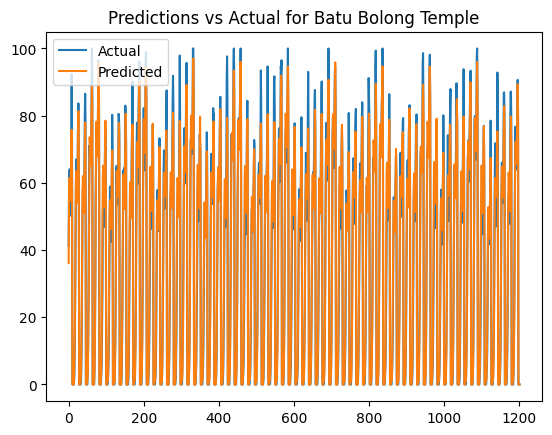

Predicted OccupancyPercent for 2024-12-25 at hour 14: 49.19%


In [27]:
df1['Year'] = pd.to_datetime(df1['Date']).dt.year
df1['YearMonth'] = pd.to_datetime(df1['Date']).dt.to_period('M').astype(str)

df1 = df1[['Title', 'Date', 'Day', 'Hour', 'OccupancyPercent', 'Year', 'YearMonth']]

location_input = input("Please enter the name of the location: ")

if location_input not in df1['Title'].unique():
    print(f"Location '{location_input}' not found in the dataset.")
else:
    location_data = df1[df1['Title'] == location_input]

    scaler = MinMaxScaler(feature_range=(0, 1))
    location_data_scaled = scaler.fit_transform(location_data[['OccupancyPercent']])

    window_size = 24
    X, y = [], []
    for i in range(window_size, len(location_data_scaled)):
        X.append(location_data_scaled[i-window_size:i, 0])
        y.append(location_data_scaled[i, 0])
    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_path = f'{location_input}_occupancy_model.h5'
    if os.path.exists(model_path):
        model = load_model(model_path)
    else:
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
            LSTM(50, return_sequences=False),
            Dense(25, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

        model.save(model_path)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    predictions = np.clip(predictions, 0, 100)
    y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_actual = np.clip(y_actual, 0, 100)

    plt.plot(y_actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(f'Predictions vs Actual for {location_input}')
    plt.legend()
    plt.show()

    def predict_custom_date(date_str, hour):
        user_date = datetime.datetime.strptime(date_str, '%Y-%m-%d')

        last_date = pd.to_datetime(location_data['Date'].max())

        if user_date < last_date:
            delta = last_date - user_date
            total_hours = delta.days * 24 + (hour - last_date.hour)
        else:
            total_hours = (user_date - last_date).days * 24 + hour

        total_hours_in_dataset = len(predictions)
        if total_hours < 0 or total_hours >= total_hours_in_dataset:
            print(f"Date and hour must be within the predicted range. Available range: {last_date} to {last_date + datetime.timedelta(hours=total_hours_in_dataset)}.")
            return

        if not (9 <= hour <= 22):
            print(f"Predicted OccupancyPercent for {date_str} at hour {hour}: 0.00% (Store Closed)")
            return

        predicted_value = predictions[total_hours - 1][0]
        predicted_value = np.clip(predicted_value, 0, 100)
        print(f"Predicted OccupancyPercent for {date_str} at hour {hour}: {predicted_value:.2f}%")

    predict_custom_date('2024-12-25', 14)


**Predicted OccupancyPercent for 2024-12-25 at hour 14: 49.19%%**
- Prediksi ini menunjukkan bahwa pada tanggal **25 Desember 2025**, pukul **14:00 (jam 2 siang)**, tingkat okupansi di Batu Bolong Temple diperkirakan berada pada **49.19%%**.
- **Tingkat okupansi (OccupancyPercent)** merepresentasikan persentase penggunaan ruang atau kapasitas di lokasi yang dimodelkan, misalnya sebuah kafe atau tempat wisata.

---

**Makna Prediksi**:
1. **Konteks Operasional**:
   - Pada waktu tersebut, tempat kemungkinan sedang memiliki aktivitas yang sedang-sedang saja, dengan tingkat okupansi mendekati setengah kapasitas.
   - Jika ini adalah kafe atau lokasi lain dengan jam sibuk di sore hari, tingkat okupansi 49.19%% dapat menunjukkan waktu yang lebih tenang dibandingkan jam-jam puncak.

2. **Pengambilan Keputusan**:
   - Jika data ini digunakan untuk perencanaan operasional, pengelola dapat mempersiapkan sumber daya seperti staf, fasilitas, atau layanan yang cukup untuk memenuhi kebutuhan tingkat okupansi ini.
   - Jika targetnya adalah meningkatkan tingkat okupansi, strategi pemasaran atau promosi khusus untuk waktu tersebut dapat dipertimbangkan.

3. **Akurasi Model**:
   - Prediksi ini bergantung pada akurasi model yang telah diuji dengan metrik seperti **RMSE, MAE, dan R²**. Dengan metrik yang cukup baik sebelumnya, kita dapat memiliki kepercayaan pada hasil prediksi ini.

---

**Tindak Lanjut**:
- Periksa hasil prediksi untuk jam-jam lain di hari yang sama untuk memahami pola tingkat okupansi sepanjang hari.
- Bandingkan prediksi ini dengan data aktual (jika tersedia di masa mendatang) untuk memvalidasi performa model pada data baru.